## Análisis de Sentimiento (in inglish pitinglish)


#### 1. Cargamos librerías

In [1]:
# imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint 
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text
from wordcloud import WordCloud
import json

# visuals
%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# spacy & regex
import re
import spacy
from spacy import displacy
from spacy.matcher import PhraseMatcher
from spacy.matcher import Matcher

# warnings
import warnings
warnings.filterwarnings('ignore')

#NLTK
from nltk.stem import *
from nltk.stem.porter import *

stemmer = PorterStemmer()

#### 2. Cargamos los datos

In [2]:
df = pd.read_csv("./input/tweets_castellano.txt", sep="::::", names=['review','review_type'] ,encoding="utf-8")
df.shape

(7219, 2)

In [3]:
df.head()

,review,review_type
0,"Salgo de #VeoTV , que día más largoooooo...",None
1,@PauladeLasHeras No te libraras de ayudar me/n...,neutro
2,@marodriguezb Gracias MAR,positivo
3,"Off pensando en el regalito Sinde, la que se v...",negativo
4,Conozco a alguien q es adicto al drama! Ja ja ...,positivo


In [4]:
# realizamos rename de las columnas
df["review_type"] =df["review_type"].replace("None", "neutro").replace(":negativo", "negativo").replace(":positivo", "positivo")

In [5]:
# vemos el nombre de las columnas del dataset
list(df.columns)

['review', 'review_type']

In [6]:
# seleccionamos las columnas necesarias
df = df[["review", "review_type"]]
df.review_type.value_counts()

positivo    2884
negativo    2183
neutro      2152
Name: review_type, dtype: int64

In [7]:
# visualizamos las columnas seleccionadas
df

,review,review_type
0,"Salgo de #VeoTV , que día más largoooooo...",neutro
1,@PauladeLasHeras No te libraras de ayudar me/n...,neutro
2,@marodriguezb Gracias MAR,positivo
3,"Off pensando en el regalito Sinde, la que se v...",negativo
4,Conozco a alguien q es adicto al drama! Ja ja ...,positivo
...,...,...
7214,Muy indignante si ...nadie repara en ello hoy ...,negativo
7215,Más pobres por discriminar a la mujer http://t...,negativo
7216,Crean un banco de productos para mujeres con c...,positivo
7217,Sobre la sorprendente huída hoy en el Senado d...,negativo


#### 5. Selección de datos

In [8]:
review_df = df.loc[df["review_type"] != "neutro"]

In [9]:
review_df.review_type.value_counts()

positivo    2884
negativo    2183
Name: review_type, dtype: int64

#### 6. ONE HOT

In [10]:
from sklearn.preprocessing import OneHotEncoder

type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  review_df.review_type.to_numpy().reshape(-1, 1)
)

In [11]:
# visualizamos el One_Hot
type_one_hot

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

#### 7. División train_reviews e y_train y test_reviews e y_test

In [12]:
train_reviews, test_reviews, y_train, y_test =\
  train_test_split(
    review_df.review, 
    type_one_hot, 
    test_size=0.15, 
    random_state=RANDOM_SEED
  )

In [13]:
# cargamos el universal sentence encoder
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [14]:
# procesamos el train
X_train = []
for r in tqdm(train_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_train.append(review_emb)

X_train = np.array(X_train)

X_test = []
for r in tqdm(test_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 761/761 [00:41<00:00, 18.27it/s]


In [15]:
print(X_train.shape, y_train.shape)

(4306, 512) (4306, 2)


#### 8. Modelo de Análisis de sentimiento

In [16]:
# model
model = keras.Sequential()

model.add(keras.layers.Dense(units=256,input_shape=(X_train.shape[1], ), activation='sigmoid'))
model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.Dense(units=128, activation='sigmoid'))
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 164,482
Trainable params: 164,482
Non-trainable params: 0
_________________________________________________________________


In [18]:
# va a monitorizar varias métricas, la precisión de validación, la pérdida, etc.
early_stopping = EarlyStopping(monitor='val_loss',patience=15)

# guarda el mejor de los Epochs
modelo_guardar = ModelCheckpoint('model_sentiment_analysis.hdf5', save_best_only=True)

In [19]:
# compilacion de modelo
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.0001),metrics=['accuracy'])

In [20]:
# training
history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stopping,modelo_guardar]) # mejor 11 epochs, bacht size 1, valdation 0.1 

Epoch 1/100
270/270 - 2s - loss: 0.8005 - accuracy: 0.5197 - val_loss: 0.6751 - val_accuracy: 0.5716 - 2s/epoch - 7ms/step
Epoch 2/100
270/270 - 1s - loss: 0.7483 - accuracy: 0.5327 - val_loss: 0.6602 - val_accuracy: 0.5716 - 908ms/epoch - 3ms/step
Epoch 3/100
270/270 - 1s - loss: 0.7214 - accuracy: 0.5430 - val_loss: 0.6501 - val_accuracy: 0.5716 - 887ms/epoch - 3ms/step
Epoch 4/100
270/270 - 1s - loss: 0.6807 - accuracy: 0.5862 - val_loss: 0.6359 - val_accuracy: 0.5716 - 927ms/epoch - 3ms/step
Epoch 5/100
270/270 - 1s - loss: 0.6632 - accuracy: 0.5954 - val_loss: 0.6195 - val_accuracy: 0.5874 - 978ms/epoch - 4ms/step
Epoch 6/100
270/270 - 1s - loss: 0.6420 - accuracy: 0.6275 - val_loss: 0.5980 - val_accuracy: 0.7477 - 937ms/epoch - 3ms/step
Epoch 7/100
270/270 - 1s - loss: 0.6185 - accuracy: 0.6554 - val_loss: 0.5718 - val_accuracy: 0.7227 - 952ms/epoch - 4ms/step
Epoch 8/100
270/270 - 1s - loss: 0.5872 - accuracy: 0.6881 - val_loss: 0.5446 - val_accuracy: 0.7372 - 945ms/epoch - 4ms/

In [21]:
from sklearn.metrics import classification_report, accuracy_score

model.load_weights("./BestMODEL_AnalisisdeSentimientos_Twitter.hdf5")

predictions = model.predict(X_test)
predictions = np.around(predictions)

print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

24/24 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       326
           1       0.92      0.83      0.87       435

   micro avg       0.86      0.86      0.86       761
   macro avg       0.86      0.87      0.86       761
weighted avg       0.87      0.86      0.86       761
 samples avg       0.86      0.86      0.86       761

0.8607095926412615


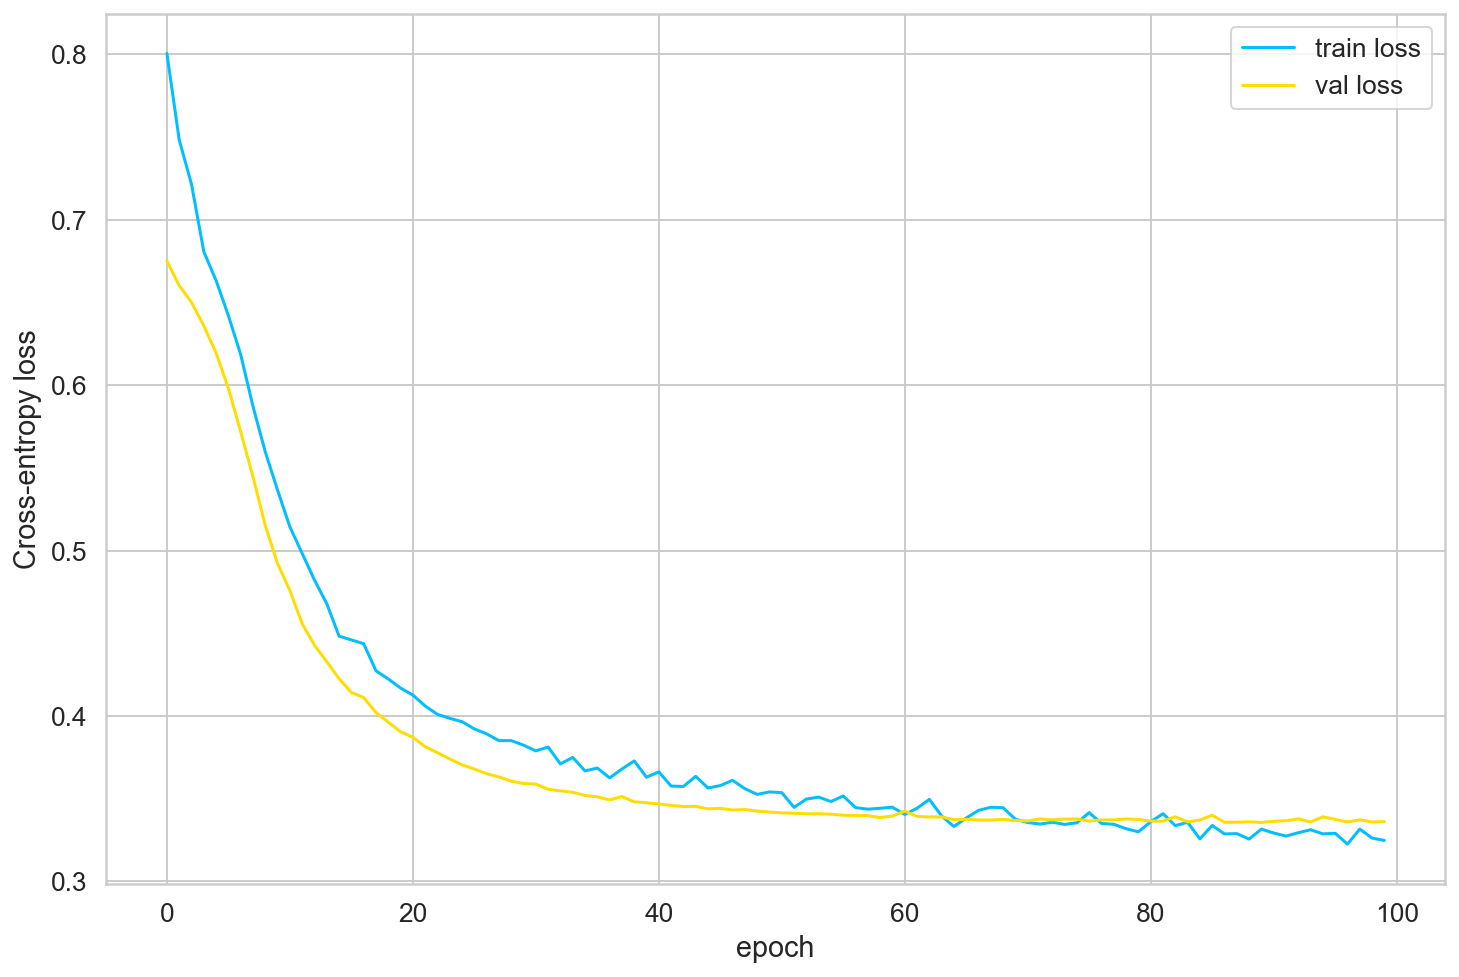

In [22]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

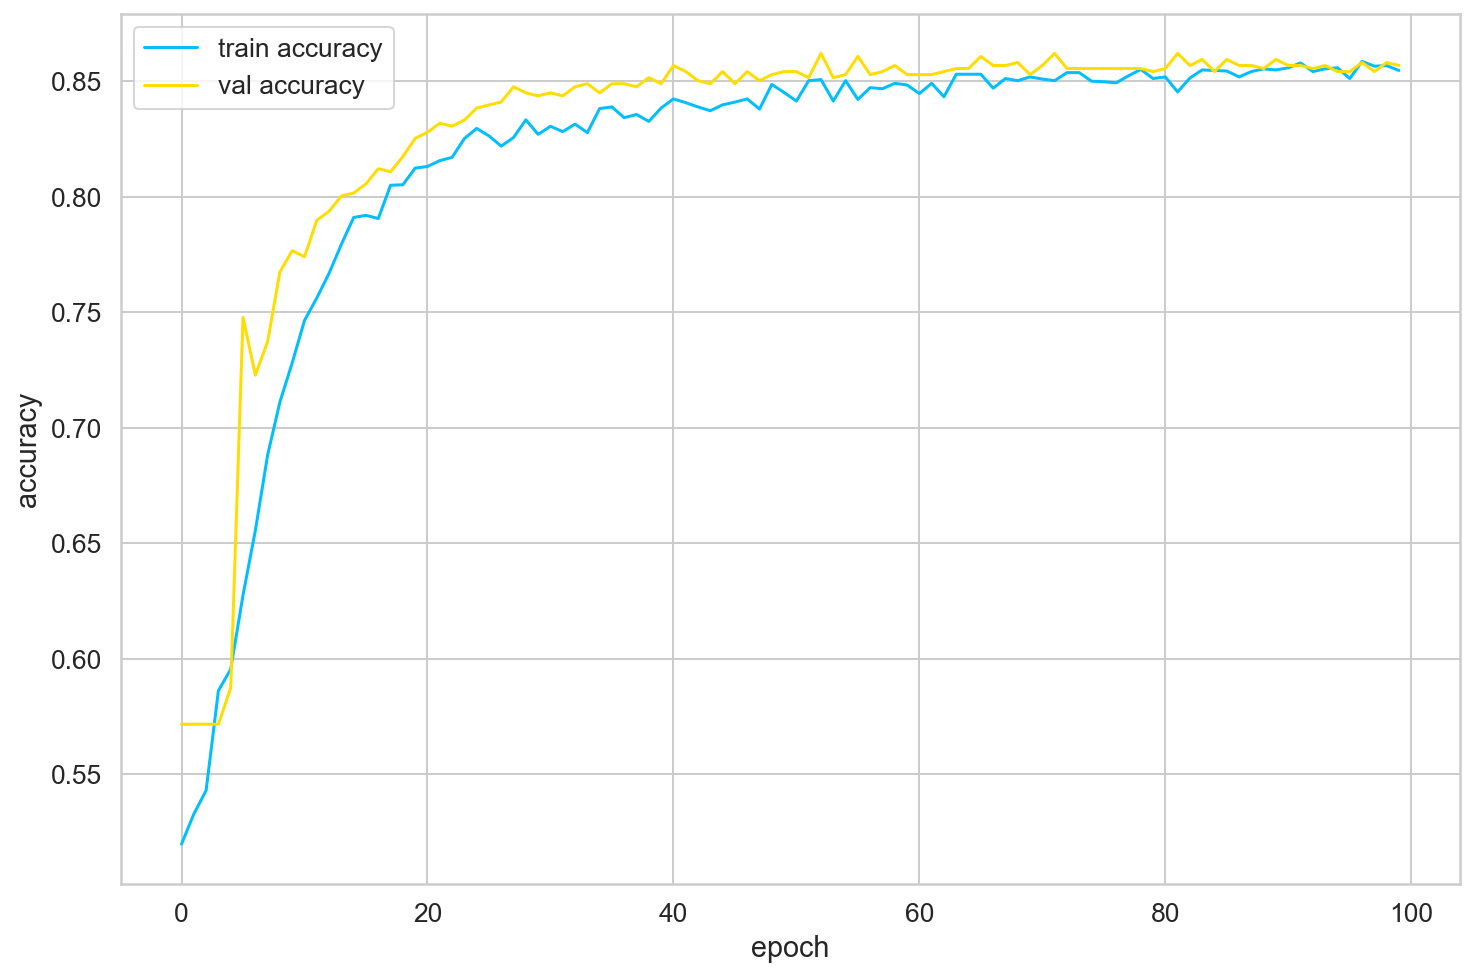

In [23]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();